In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.formula.api import logit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,auc,precision_recall_curve

## Wczytanie i obróbka danych

In [81]:
train = pd.read_excel('final_train_data.xlsx')
test = pd.read_excel('final_test_data.xlsx')

In [82]:
test.dropna(inplace=True)

In [83]:
# liczebności w zbiorach
print("test:",test.shape[0])
print("train:",train.shape[0])

test: 2054
train: 7946


In [84]:
cols = train.loc[:, train.columns != 'Status'].columns

In [85]:
train.loc[train['Status'] == 'Late', 'Status'] = 1
train.loc[train['Status'] == 'Current', 'Status'] = 0
test.loc[test['Status'] == 'Late', 'Status'] = 1
test.loc[test['Status'] == 'Current', 'Status'] = 0

In [86]:
for v in ['OccupationArea', 'ActiveScheduleFirstPaymentReached', 
          'PrincipalOverdueBySchedule', 'Restructured']:
    print(v, test[v].unique())

OccupationArea [0. 1.]
ActiveScheduleFirstPaymentReached [1. 0.]
PrincipalOverdueBySchedule [1. 0.]
Restructured [0. 1.]


In [87]:
for v in cols:
    if v in ['OccupationArea', 'ActiveScheduleFirstPaymentReached', 
          'PrincipalOverdueBySchedule', 'Restructured']:
        test[v] = test[v].astype(int).astype(str)
    else:
        test[v] = test[v].astype(str)

In [88]:
for v in cols:
    train[v] = train[v].astype(str)

In [89]:
# train.dtypes

In [90]:
# test.dtypes

In [91]:
print("Train default rate:", len(train[train['Status'] == 1]) / len(train))
print("Test default rate:", len(test[test['Status'] == 1]) / len(test))

Train default rate: 0.5922476717845457
Test default rate: 0.6090555014605648


## Transformacja zmiennych w oparciu o WoE

In [92]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d0 = d0.astype({"x": str})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Non-Events']/d['% of Events'])
        d['IV'] = d['WoE'] * (d['% of Non-Events']-d['% of Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)
        newDF.reset_index(drop=True, inplace=True)
        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [93]:
iv, woe = iv_woe(data = train, target = 'Status')

In [269]:
# sprawdzenie, czy algorytm nie namieszał w przedziałach
# for col in cols:
#     print(col)
#     print('Train:', train[col].unique())
#     print('WoE:', np.array(woe[woe['Variable'] == col]['Cutoff']))

In [96]:
woe.head(3)

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,LanguageCode,3_1,4364,2149,0.456651,2215,0.683642,0.403515,0.091594
1,LanguageCode,4_2,2439,1567,0.332979,872,0.269136,-0.212864,0.013590
2,LanguageCode,6,1143,990,0.210370,153,0.047222,-1.494002,0.243743


In [97]:
# Wyrzucenie zbyt dobrych zmiennych, które zwiększają ryzyko przeuczenia modelu
cut = 0.6
exclude_list = iv[iv['IV'] > cut]['Variable'].unique()
m_vars = [v for v in cols if v not in exclude_list]
print(iv[iv['IV'] > cut])

                             Variable        IV
3                            Interest  0.644025
15  ActiveScheduleFirstPaymentReached  2.313826
16            PlannedInterestTillDate  1.853650
17                       ExpectedLoss  1.023074
19               ProbabilityOfDefault  0.650977
20         PrincipalOverdueBySchedule  9.494501
22                             Rating  0.711741


In [113]:
# przekodowanie wariantów zmiennych na wartości WoE
def data_to_woe(df):
    df_woe = df.copy()
    for v in cols:
        df_woe = df_woe.merge(
            woe[woe['Variable'] == v][['Cutoff', 'WoE']],
            how='left',
            left_on=v, 
            right_on='Cutoff'
        )
        df_woe.drop(columns=['Cutoff', v], inplace=True)
        df_woe.rename(columns={'WoE': v}, inplace=True)
    df_woe['Status'] = df_woe['Status'].astype(int)
    return df_woe

In [136]:
train_woe = data_to_woe(train)
test_woe = data_to_woe(test)

In [137]:
# Brakujące dane przez brak kategorii w zbiorze testowym
df = test_woe.copy()
print('Braki:')
print('%       ','N     ','VAR')
for i in df.columns:
    print("{:4.2f}".format(round(len(df[df[i].isna()]) / len(df), 2)), "  ", "{:4}".format(len(df[df[i].isna()])), "  ",i)

Braki:
%        N      VAR
0.00       0    Status
0.85    1739    LanguageCode
0.00       0    Gender
0.00       0    Country
0.00       0    Interest
0.00       0    LoanDuration
0.00       0    MonthlyPayment
0.00       0    UseOfLoan
0.00       0    MaritalStatus
0.00       0    EmploymentStatus
0.00       0    OccupationArea
0.00       0    HomeOwnershipType
0.00       0    IncomeFromPrincipalEmployer
0.00       0    ExistingLiabilities
0.00       0    DebtToIncome
0.00       0    FreeCash
0.00       0    ActiveScheduleFirstPaymentReached
0.00       0    PlannedInterestTillDate
0.00       0    ExpectedLoss
0.00       0    ExpectedReturn
0.00       0    ProbabilityOfDefault
0.00       0    PrincipalOverdueBySchedule
0.00       0    ModelVersion
0.00       0    Rating
1.00    2054    Restructured
0.00       0    CreditScoreEsMicroL
0.00       0    InterestAndPenaltyPaymentsMade
0.00       0    NoOfPreviousLoansBeforeLoan
0.00       0    AmountOfPreviousLoansBeforeLoan


In [138]:
# Usunięcie zmiennych z brakami
train_woe.drop(columns=['LanguageCode' ,'Restructured'], inplace=True)
test_woe.drop(columns=['LanguageCode' ,'Restructured'], inplace=True)

m_vars = [v for v in m_vars if v not in ['LanguageCode' ,'Restructured']]

## Estymacja modelu scoringowego

In [139]:
def plot_roc_pre_recall_curve(labels, probs):
    from sklearn.metrics import precision_recall_curve
    # Get ROC curve FPR and TPR from true labels vs score values
    fpr, tpr, _ = roc_curve(labels, probs)

    # Calculate ROC Area Under the Curve (AUC) from FPR and TPR data points
    roc_auc = auc(fpr, tpr)

    # Calculate precision and recall from true labels vs score values
    precision, recall, _ = precision_recall_curve(labels, probs)

    plt.figure(figsize=(16, 6))

    plt.subplot(1,2,1)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.step(recall, precision, color='orange', where='post')
    # plt.fill_between(recall, precision, step='post', alpha=0.5, color='orange')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision Recall Curve')
    plt.grid(True)

    left  = 0.125  # the left side of the subplots of the figure
    right = 0.9    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom of the subplots of the figure 
    top = 0.9      # the top of the subplots of the figure
    wspace = 0.5   # the amount of width reserved for blank space between subplots
    hspace = 0.2   # the amount of height reserved for white space between subplots
    plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
    plt.show()

In [140]:
x_train = train_woe[m_vars]
y_train = train_woe['Status']
x_test =test_woe[m_vars] 
y_test = test_woe['Status']

In [141]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

LogisticRegression()

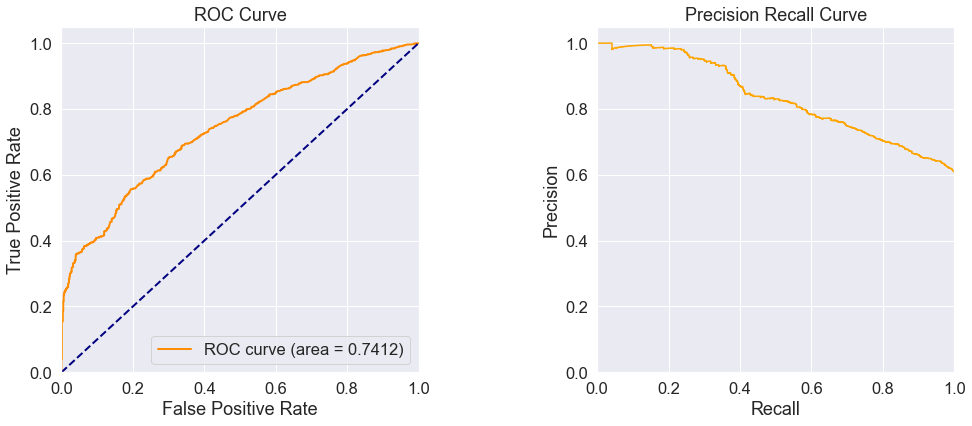

In [142]:
#check AUC
probs = lr.predict_proba(x_test)[:,1]
sns.set(font_scale = 1.5)
plot_roc_pre_recall_curve(y_test, probs)

In [143]:
features = pd.DataFrame(zip(x_train.columns, np.transpose(lr.coef_)), columns=['features', 'coef'])

In [144]:
for i in range(0, len(features)):
    features['coef'][i] = features['coef'][i][0]

In [145]:
features

,features,coef
0,Gender,-0.804904
1,Country,-0.405106
2,LoanDuration,-0.130576
3,MonthlyPayment,-1.21863
4,UseOfLoan,-0.0871905
5,MaritalStatus,-0.0871905
6,EmploymentStatus,0.188634
7,OccupationArea,-0.0871905
8,HomeOwnershipType,-0.402424
9,IncomeFromPrincipalEmployer,-0.0125788


## Karta scoringowa

In [204]:
base_score = 500
base_odds = 1
pdo = 20

In [208]:
intercept_score = base_score + pdo / np.log(2) * lr.intercept_[0] - 1

In [209]:
intercept_score

513.1444754312346

In [210]:
scorecard = woe[woe['Variable'].isin(features['features'].unique())][['Variable', 'Cutoff', 'WoE']]
scorecard = scorecard.merge(features, left_on='Variable', right_on='features')
scorecard['Score'] = scorecard['WoE'] * scorecard['coef'] * -1 * pdo / np.log(2)
scorecard.drop(columns=['features', 'coef', 'WoE'], inplace=True)
scorecard.rename(columns={'Cutoff': 'Category'}, inplace=True)

In [211]:
scorecard

,Variable,Category,Score
0,Gender,1,11.1318
1,Gender,2_0,-6.3195
2,Country,EE,5.78178
3,Country,ES_FI,-8.15069
4,LoanDuration,<=48,-1.54229
5,LoanDuration,>48,0.698256
6,MonthlyPayment,"<=109,9",11.7417
7,MonthlyPayment,">109,9",-19.507
8,UseOfLoan,<=-1,0.178682
9,UseOfLoan,>-1,-13.6041


## Wyliczenie scorów dla danych testowych

In [234]:
def data_to_score(df):
    cols = scorecard['Variable'].unique()
    df_score = df[np.append(cols, 'Status')]
    for v in cols:
        df_score = df_score.merge(
            scorecard[scorecard['Variable'] == v][['Category', 'Score']],
#             how='left',
            left_on=v, 
            right_on='Category'
        )
        df_score.drop(columns=['Category', v], inplace=True)
        df_score.rename(columns={'Score': v}, inplace=True)
    df_score['Status'] = df_score['Status'].astype(int)
    df_score['Intercept'] = intercept_score
    df_score['Score'] = df_score.drop('Status', axis=1).sum(axis=1)
    return df_score

In [235]:
test_score = data_to_score(test)

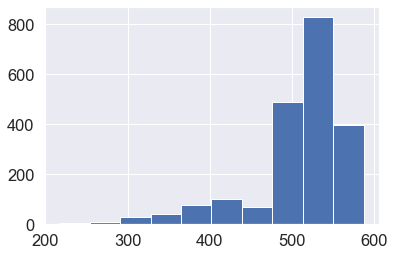

In [238]:
# ogólny rozkład
test_score['Score'].hist()

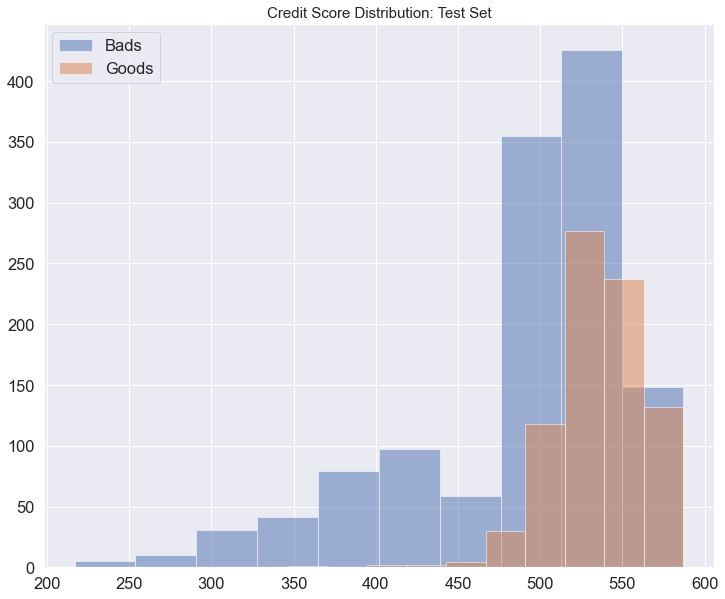

In [266]:
# rozkład w podziale na default
# chujowo wychodzi bo mamy bardzo duży default rate na poziomie ok 0.6
plt.figure(figsize=(12,10))
import random
import math
from matplotlib import pyplot as plt

w = 40
n = math.ceil((test_score['Score'].max() - test_score['Score'].min())/w)
#bins = numpy.linspace(-10, 10, 100)

plt.hist(test_score[test_score.Status==1].Score, alpha=0.5, label='Bads',bins = n)
plt.hist(test_score[test_score.Status==0].Score, alpha=0.5, label='Goods',bins = n)
plt.legend(loc='upper left')
plt.title('Credit Score Distribution: Test Set',size=15)
plt.show()

In [263]:
np.percentile(test_score['Score'], np.arange(0, 100, 10))

array([216.8346556 , 414.02398919, 480.83365823, 502.42463357,
       512.43466893, 523.54104215, 530.952757  , 538.48804796,
       549.39745641, 561.82694924])

In [267]:
test_score['Decile'] = pd.qcut(test_score['Score'], 10, labels=False)
score_deciles = test_score.groupby(by=['Decile']).sum().reset_index()
score_deciles['N'] = score_deciles['Intercept'] / intercept_score
score_deciles['BadRate'] = score_deciles['Status'] / score_deciles['N']
score_deciles.drop(columns=['Status', 'Intercept', 'Score'], inplace=True)

In [268]:
score_deciles

,Decile,N,BadRate
0,0,207.0,0.985507
1,1,207.0,0.903382
2,2,202.0,0.638614
3,3,206.0,0.752427
4,4,206.0,0.567961
5,5,204.0,0.578431
6,6,210.0,0.476190
7,7,204.0,0.455882
8,8,205.0,0.424390
9,9,203.0,0.300493
